In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from config import get_config_from_file, get_default_config
from evaluation.confidence_model import StatistcsConfidenceModel
from netcal.presentation import ReliabilityRegression
from netcal import is_in_quantile

# unsupervised calibration visualization

In [71]:
mode = "unsupervised"
method_names = ['ICA', 'CHROM', 'GREEN', 'LGI', 'OMIT', 'PBV', 'POS']
dataset_names = ["PURE", "UBFC-rPPG", "UBFC-Phys", "iBVP", "MAHNOB"]

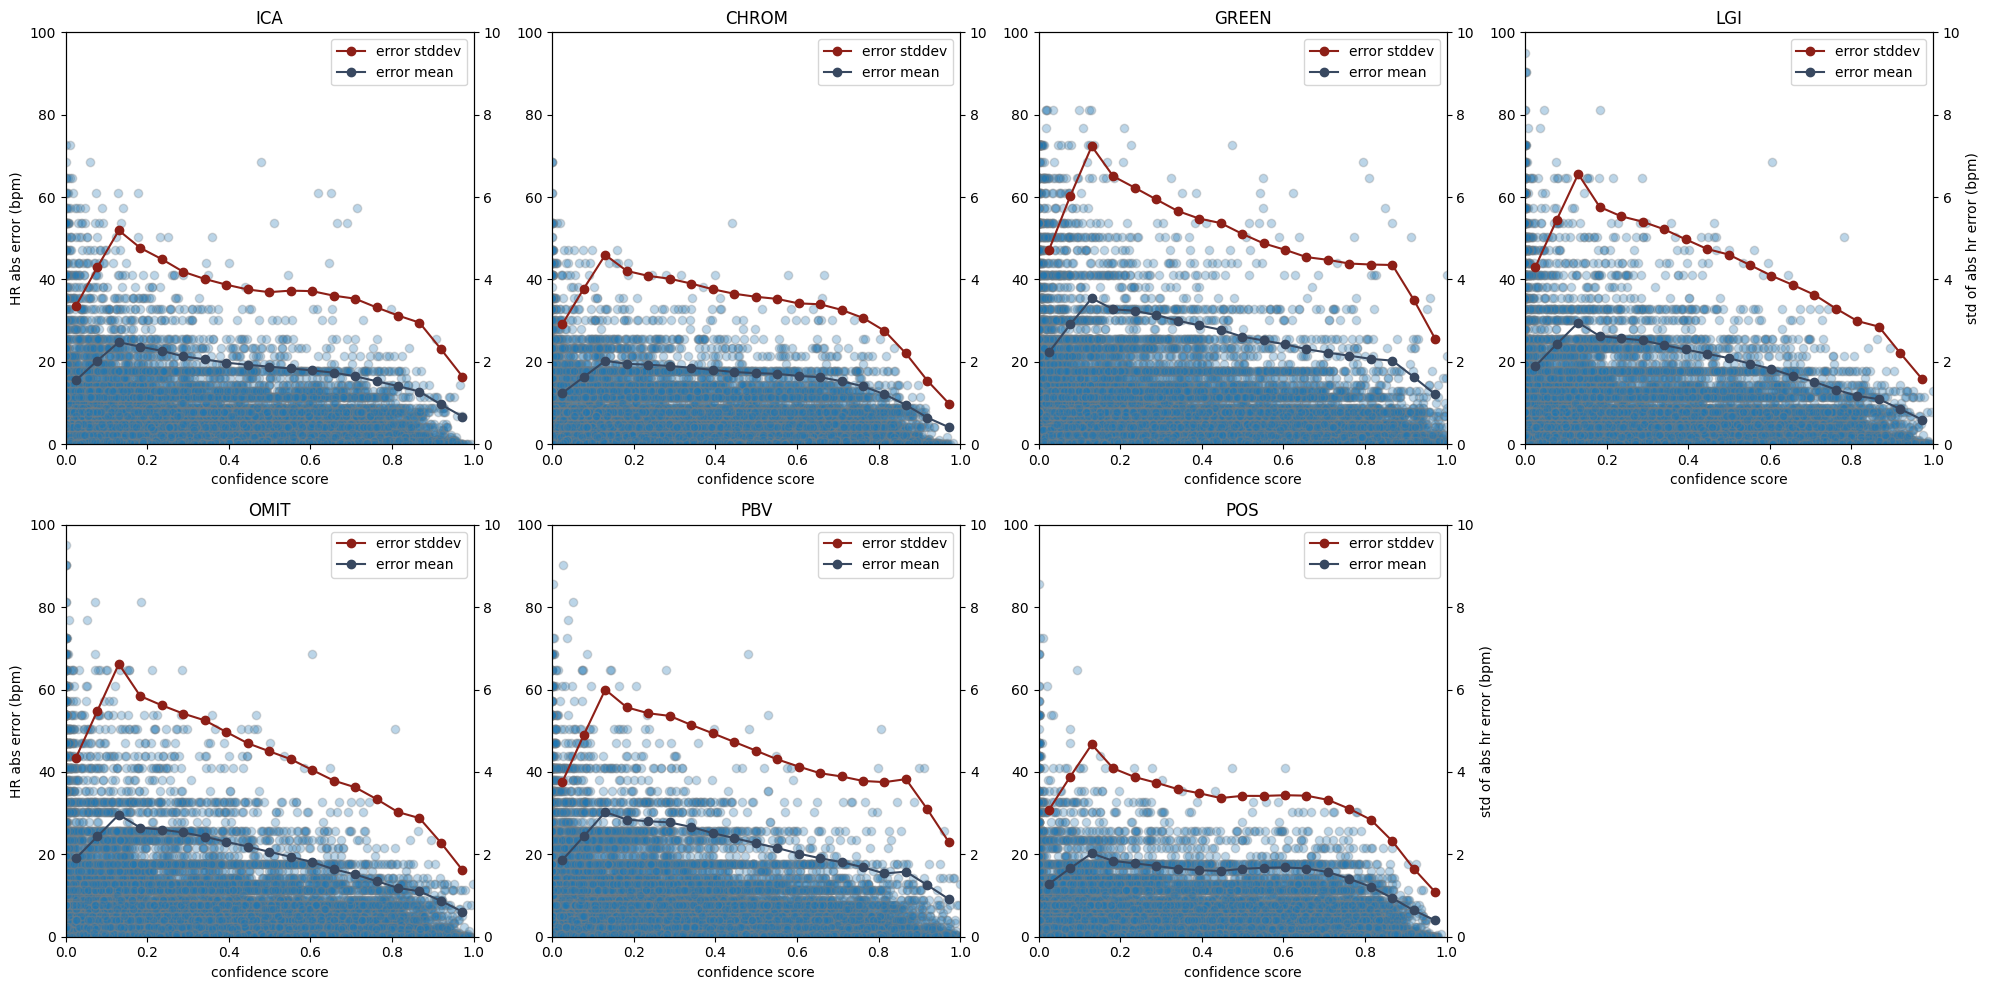

In [72]:
# confidence vs error
confidence_model = StatistcsConfidenceModel(get_default_config())
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, method in enumerate(method_names):

    dfs = []
    for dataset_name in dataset_names:
        df = pd.read_csv(f"results/{mode}_inference/{dataset_name}_unsupervised_inference/{method}_metrics.csv")
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
        
    confidence = df['confidence_percentile'].values
    hr_abs_error = df['abs_hr_error'].values
    transformed_hr_abs_error = (hr_abs_error / 100) ** 2.5 * 100
    
    confidence_bins = np.linspace(0, 1, 20)
    hr_abs_error_means = []
    hr_abs_error_stds = []
    for confidence_bin_idx in range(len(confidence_bins) - 1):
        confidence_idx = (confidence >= confidence_bins[confidence_bin_idx]) & (confidence < confidence_bins[confidence_bin_idx+1])
        if sum(confidence_idx) > 1:
            hr_abs_error_stds.append(np.std(transformed_hr_abs_error[confidence_idx]))
            hr_abs_error_means.append(np.mean(transformed_hr_abs_error[confidence_idx]))
        else:
            hr_abs_error_stds.append(hr_abs_error_stds[-1])
            hr_abs_error_means.append(hr_abs_error_means[-1])
    hr_abs_error_stds = np.array(hr_abs_error_stds)
    hr_abs_error_means = np.array(hr_abs_error_means)
    
    window_size = 5
    kernel = np.ones(window_size) / window_size
    hr_abs_error_means = np.convolve(hr_abs_error_means, kernel, mode='same')
    hr_abs_error_stds = np.convolve(hr_abs_error_stds, kernel, mode='same')
    
    ax2 = axes[i].twinx()
    ax2.plot(confidence_bins[:-1] + 0.025, hr_abs_error_stds, "o-", color='#8d1f17', label="error stddev")
    ax2.plot(confidence_bins[:-1] + 0.025, hr_abs_error_means, "o-", color='#384860', label="error mean") 
    ax2.set_ylim(0, 10)
    ax2.legend()
        
    axes[i].scatter(confidence, transformed_hr_abs_error, alpha=0.3, edgecolors='grey')
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 100)
    axes[i].set_xlabel('confidence score')
    axes[i].set_title(method)

    if i==0 or i==4:
        axes[i].set_ylabel('HR abs error (bpm)')
    if i==3 or i==6:
        ax2.set_ylabel('std of abs hr error (bpm)')
    
axes[-1].set_visible(False)

plt.tight_layout()
# plt.savefig(f'results/svgs/confidence_unsupervised.svg', dpi=300, bbox_inches='tight', format='svg')
plt.savefig(f'results/svgs/confidence_unsupervised.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

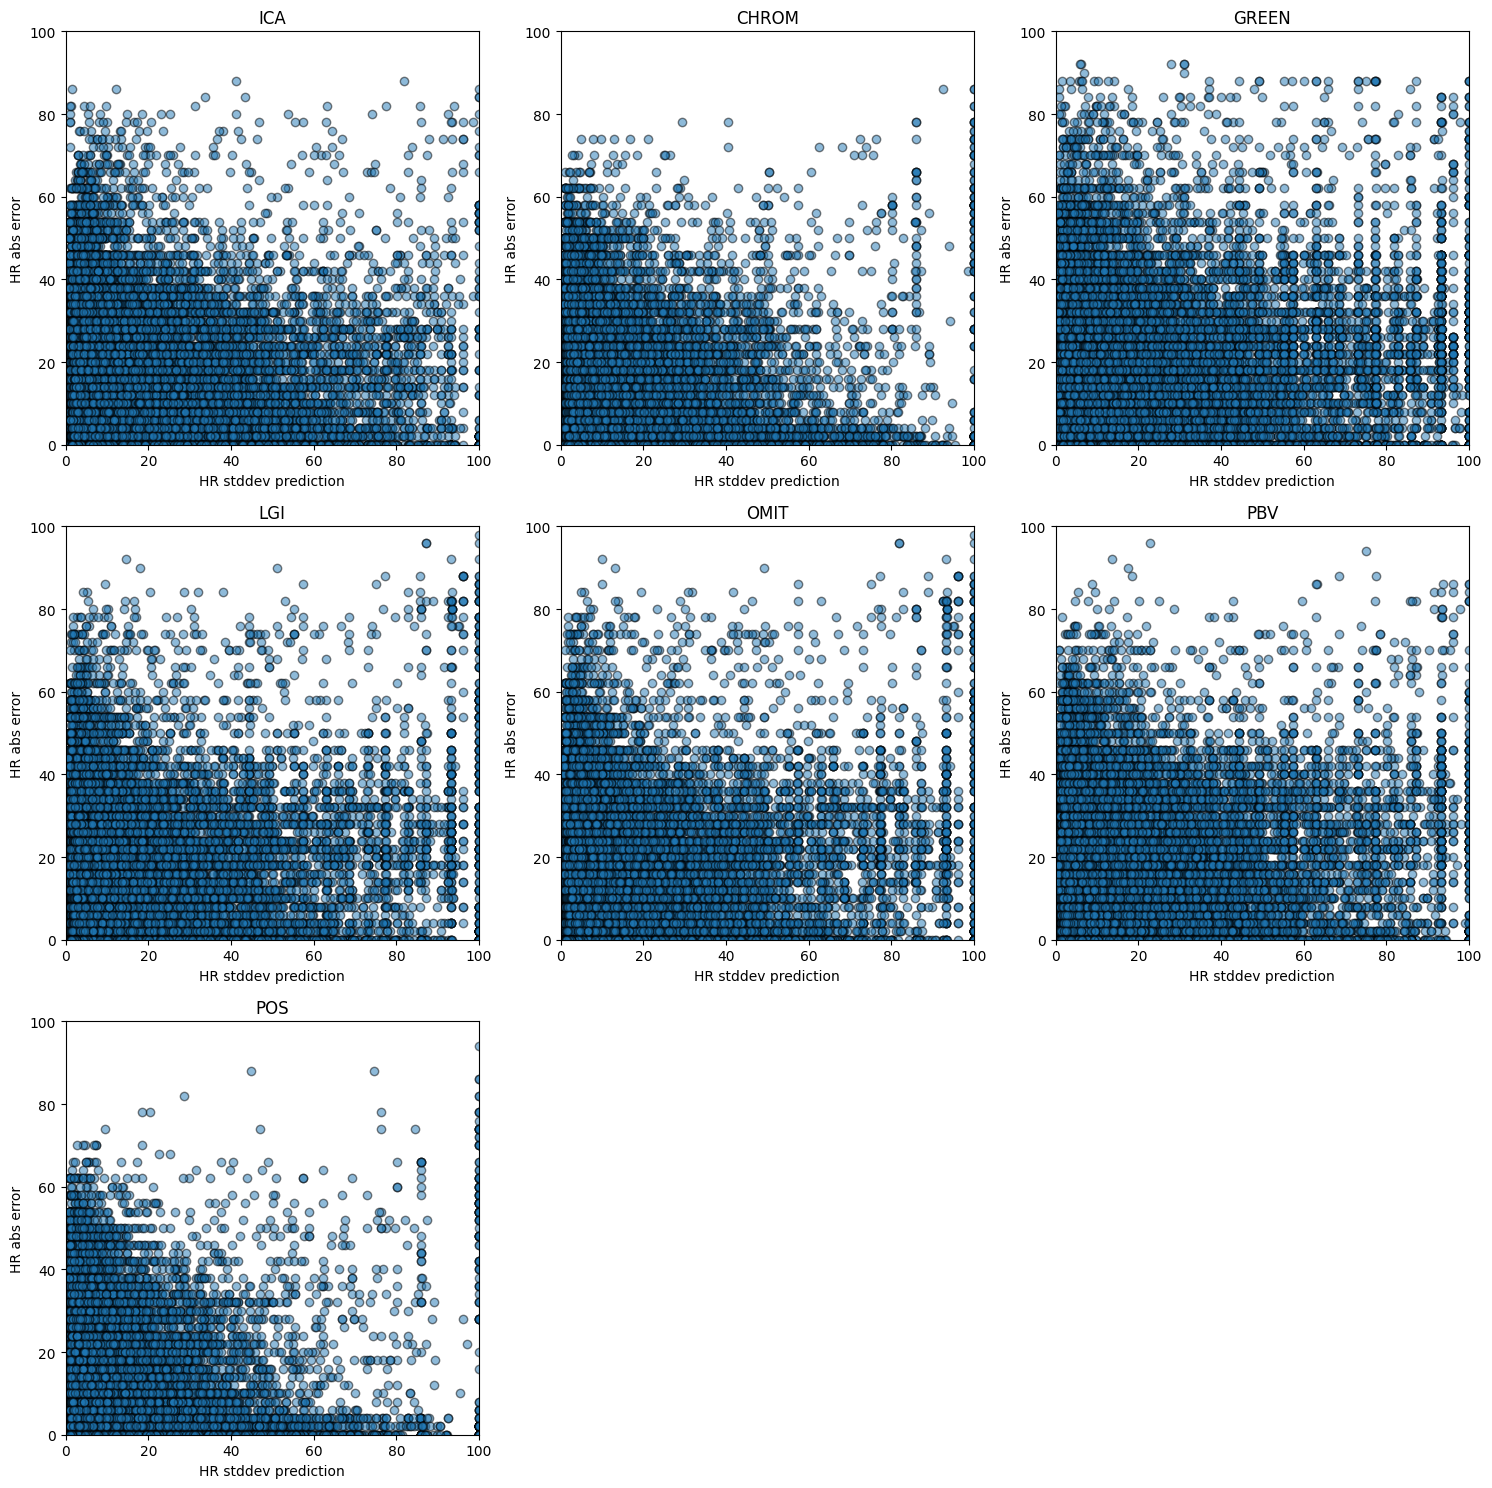

In [26]:
# std vs error
confidence_model = StatistcsConfidenceModel(get_default_config())
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, method in enumerate(method_names):

    dfs = []
    for dataset_name in dataset_names:
        df = pd.read_csv(f"results/{mode}_inference/{dataset_name}_unsupervised_inference/{method}_metrics.csv")
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
        
    confidence = df['confidence_percentile'].values
    hr_abs_error = df['abs_hr_error'].values
    hr_std = [confidence_model.confidence_to_std(c) for c in confidence]
        
    axes[i].scatter(hr_std, hr_abs_error, alpha=0.5, edgecolors='black')
    axes[i].set_xlim(0, 100)
    axes[i].set_ylim(0, 100)
    axes[i].set_aspect('equal')
    axes[i].set_xlabel('HR stddev prediction')
    axes[i].set_ylabel('HR abs error')
    axes[i].set_title(method)

# Hide the last empty subplot since we only have 7 methods
axes[-1].set_visible(False)
axes[-2].set_visible(False)

plt.tight_layout()
plt.show()

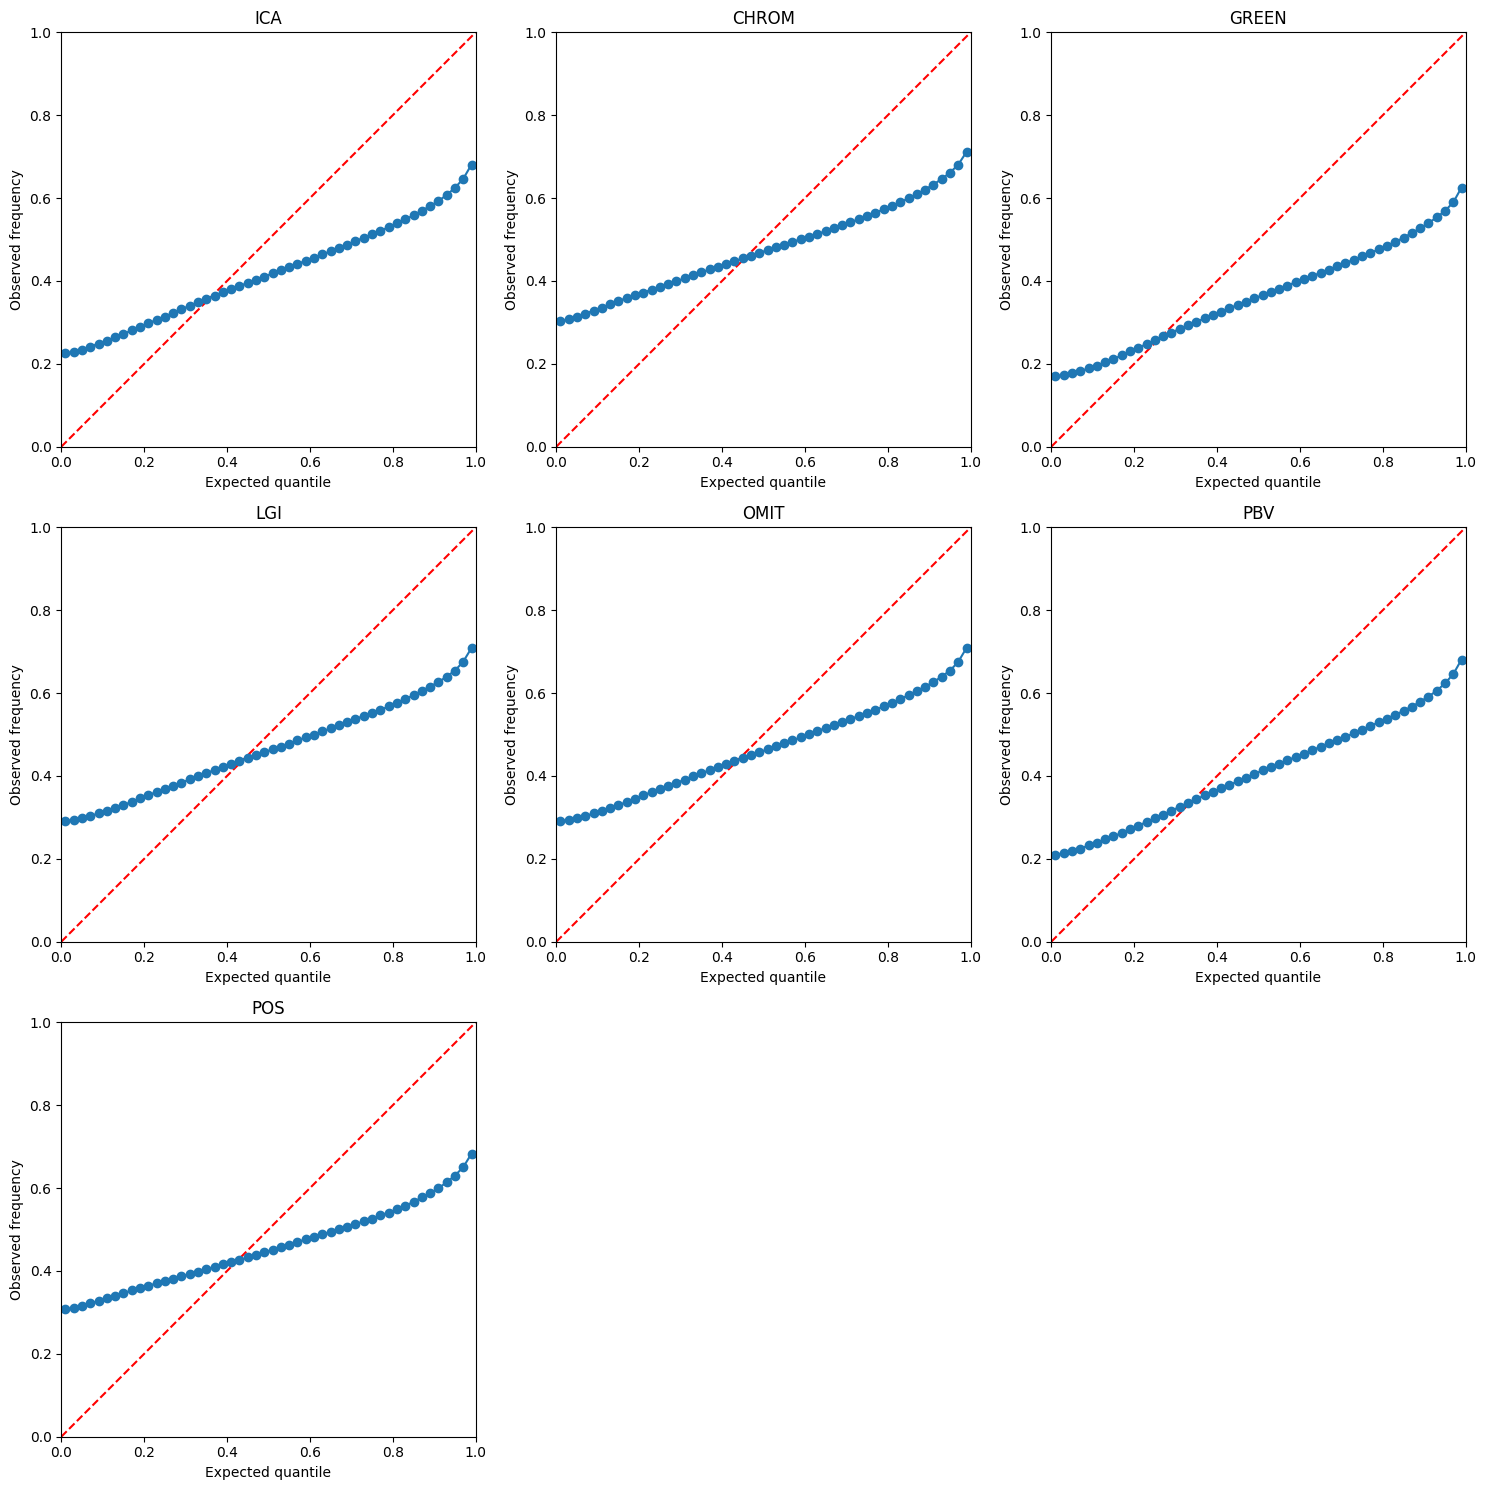

In [ ]:
# reliability diagram
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, method in enumerate(method_names):

    dfs = []
    for dataset_name in dataset_names:
        df = pd.read_csv(f"results/{mode}_inference/{dataset_name}_unsupervised_inference/{method}_metrics.csv")
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
        
    confidence = df['confidence_percentile'].values
    hr_abs_error = df['abs_hr_error'].values
    df['hr_std'] = [confidence_model.confidence_to_std(c) for c in confidence]

    mean = np.array(df['hr_pred']).reshape(-1, 1)
    stddev = np.array(df['hr_std']).reshape(-1, 1)
    ground_truth = np.array(df['hr_label']).reshape(-1, 1)

    # plot
    quantiles = np.linspace(0.01, 0.99, 50)
    in_quantile, _, _, _, _ = is_in_quantile((mean, stddev), ground_truth, quantiles, kind="meanstd")
    frequency = np.mean(in_quantile, axis=1)
    
    axes[i].plot([0, 1], [0, 1], color='red', linestyle='--')
    axes[i].plot(quantiles, frequency, "o-")
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    axes[i].set_aspect('equal')
    axes[i].set_xlabel('Expected quantile')
    axes[i].set_ylabel('Observed frequency')
    axes[i].set_title(method)

# Hide the last empty subplot since we only have 7 methods
axes[-1].set_visible(False)
axes[-2].set_visible(False)

plt.tight_layout()
plt.show()

# supervised calibration visualization

In [85]:
mode = "supervised"
method_names = ['deepphys', 'efficientphys', 'factorizephys', 'ibvpnet', 'physformer', 'physnet', 'rhythmformer', 'tscan']
trained_dataset = "pure"
dataset_names = ["PURE", "UBFC-rPPG", "UBFC-Phys", "iBVP"]

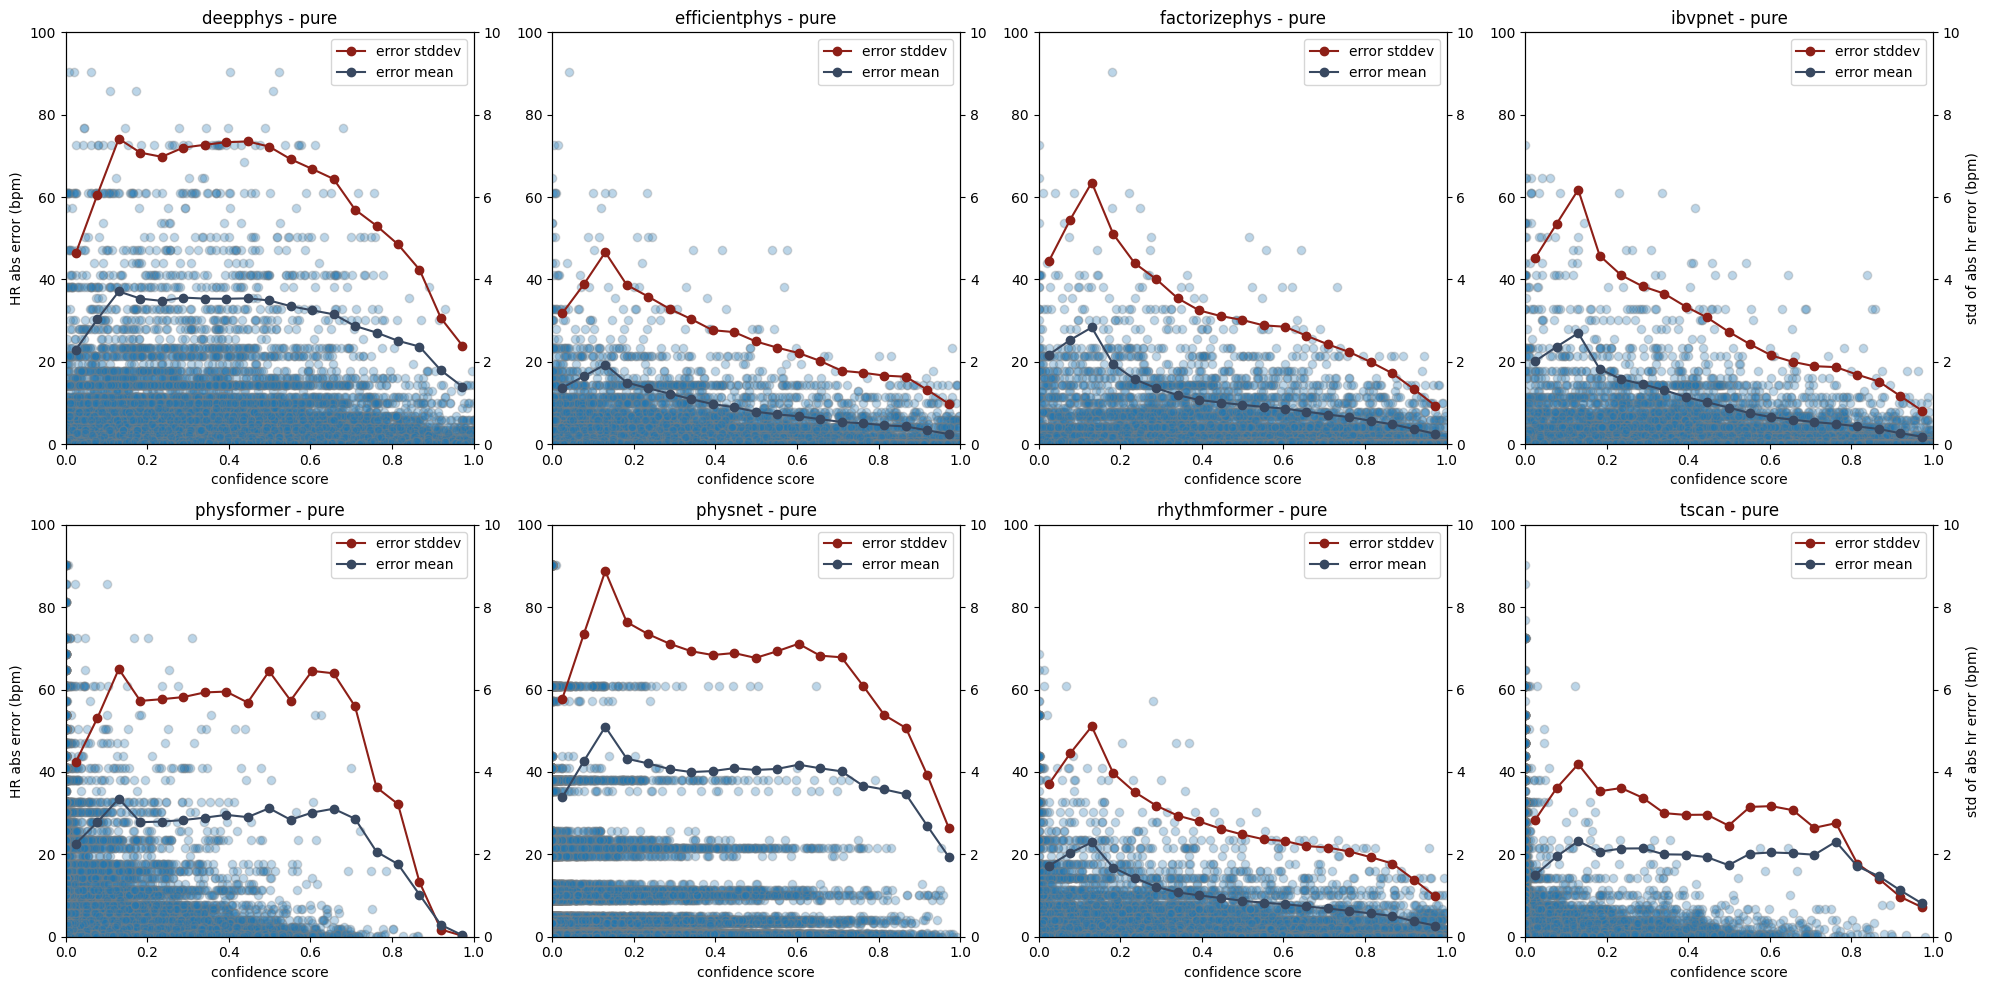

In [86]:
# confidence vs error
confidence_model = StatistcsConfidenceModel(get_default_config())
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, method in enumerate(method_names):

    dfs = []
    for dataset_name in dataset_names:
        csv_path = f"results/{mode}_inference/{dataset_name}_{method}_inference/{method}-{trained_dataset}_metrics.csv"
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
        
    confidence = df['confidence_percentile'].values
    hr_abs_error = df['abs_hr_error'].values
    transformed_hr_abs_error = (hr_abs_error / 100) ** 2.5 * 100
    
    confidence_bins = np.linspace(0, 1, 20)
    hr_abs_error_means = []
    hr_abs_error_stds = []
    for confidence_bin_idx in range(len(confidence_bins) - 1):
        confidence_idx = (confidence >= confidence_bins[confidence_bin_idx]) & (confidence < confidence_bins[confidence_bin_idx+1])
        if sum(confidence_idx) > 1:
            hr_abs_error_stds.append(np.std(transformed_hr_abs_error[confidence_idx]))
            hr_abs_error_means.append(np.mean(transformed_hr_abs_error[confidence_idx]))
        else:
            hr_abs_error_stds.append(hr_abs_error_stds[-1])
            hr_abs_error_means.append(hr_abs_error_means[-1])
    hr_abs_error_stds = np.array(hr_abs_error_stds)
    hr_abs_error_means = np.array(hr_abs_error_means)
    
    window_size = 5
    kernel = np.ones(window_size) / window_size
    hr_abs_error_means = np.convolve(hr_abs_error_means, kernel, mode='same')
    hr_abs_error_stds = np.convolve(hr_abs_error_stds, kernel, mode='same')
    
    ax2 = axes[i].twinx()
    ax2.plot(confidence_bins[:-1] + 0.025, hr_abs_error_stds, "o-", color='#8d1f17', label="error stddev")
    ax2.plot(confidence_bins[:-1] + 0.025, hr_abs_error_means, "o-", color='#384860', label="error mean") 
    ax2.set_ylim(0, 10)
    ax2.legend()
        
    axes[i].scatter(confidence, transformed_hr_abs_error, alpha=0.3, edgecolors='grey')
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 100)
    axes[i].set_xlabel('confidence score')
    axes[i].set_title(f"{method} - {trained_dataset}")

    if i==0 or i==4:
        axes[i].set_ylabel('HR abs error (bpm)')
    if i==3 or i==7:
        ax2.set_ylabel('std of abs hr error (bpm)')

plt.tight_layout()
plt.savefig(f'results/svgs/confidence_supervised.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

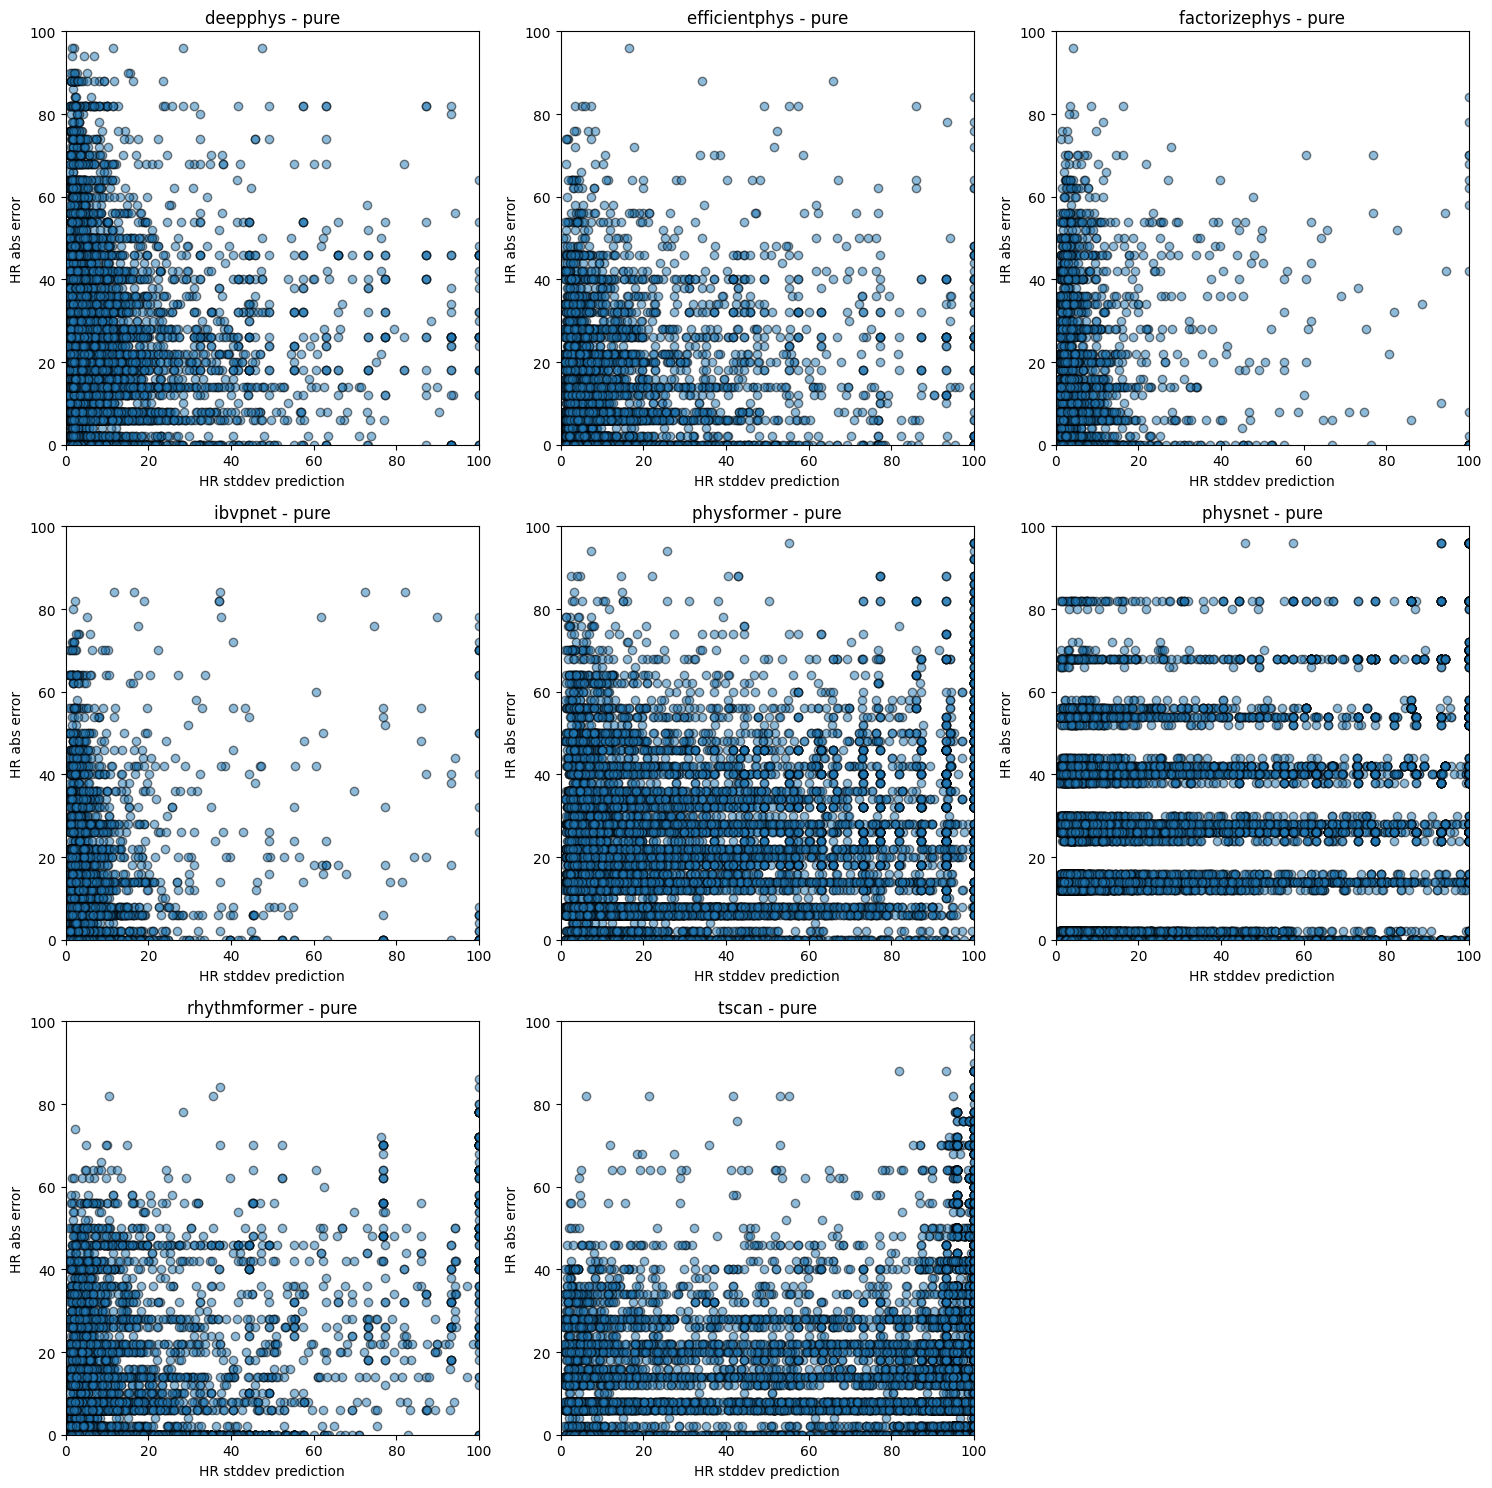

In [42]:
# std vs error
confidence_model = StatistcsConfidenceModel(get_default_config())
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, method in enumerate(method_names):

    dfs = []
    for dataset_name in dataset_names:
        csv_path = f"results/{mode}_inference/{dataset_name}_{method}_inference/{method}-{trained_dataset}_metrics.csv"
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
        
    confidence = df['confidence_percentile'].values
    hr_abs_error = df['abs_hr_error'].values
    hr_std = [confidence_model.confidence_to_std(c) for c in confidence]
        
    axes[i].scatter(hr_std, hr_abs_error, alpha=0.5, edgecolors='black')
    axes[i].set_xlim(0, 100)
    axes[i].set_ylim(0, 100)
    axes[i].set_aspect('equal')
    axes[i].set_xlabel('HR stddev prediction')
    axes[i].set_ylabel('HR abs error')
    axes[i].set_title(f'{method} - {trained_dataset}')

axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

In [1]:
# reliability diagram
fig, axes = plt.subplots(2, 4, figsize=(15, 15))
axes = axes.flatten()

for i, method in enumerate(method_names):

    dfs = []
    for dataset_name in dataset_names:
        csv_path = f"results/{mode}_inference/{dataset_name}_{method}_inference/{method}-{trained_dataset}_metrics.csv"
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
        
    confidence = df['confidence_percentile'].values
    hr_abs_error = df['abs_hr_error'].values
    df['hr_std'] = [confidence_model.confidence_to_std(c) for c in confidence]

    mean = np.array(df['hr_pred']).reshape(-1, 1)
    stddev = np.array(df['hr_std']).reshape(-1, 1)
    ground_truth = np.array(df['hr_label']).reshape(-1, 1)

    # plot
    quantiles = np.linspace(0.01, 0.99, 50)
    in_quantile, _, _, _, _ = is_in_quantile((mean, stddev), ground_truth, quantiles, kind="meanstd")
    frequency = np.mean(in_quantile, axis=1)
    
    axes[i].plot([0, 1], [0, 1], color='red', linestyle='--')
    axes[i].plot(quantiles, frequency, "o-")
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    axes[i].set_aspect('equal')
    axes[i].set_xlabel('Expected quantile')
    axes[i].set_ylabel('Observed frequency')
    axes[i].set_title(f'{method} - {trained_dataset}')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

# PCA analysis of psds

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

(47945, 129)


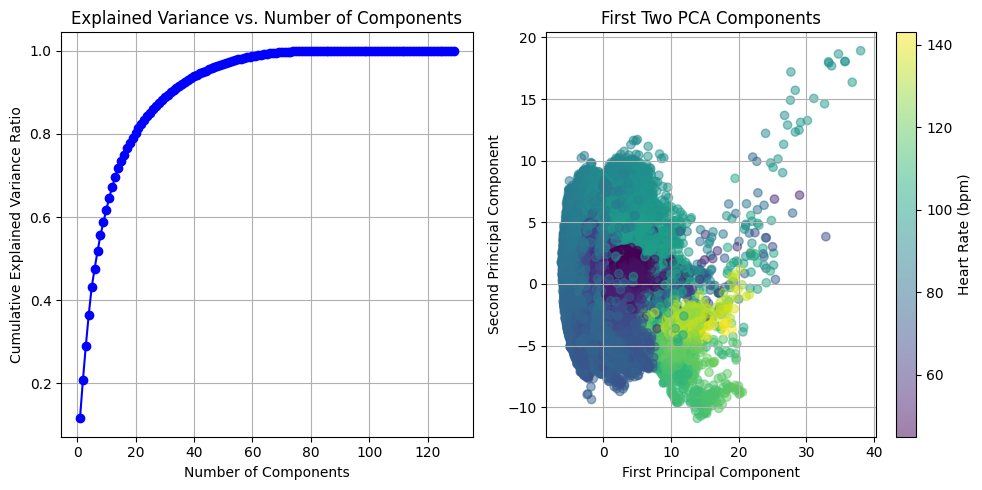

Explained variance ratio for first 5 components:
Component 1: 0.116
Component 2: 0.092
Component 3: 0.083
Component 4: 0.075
Component 5: 0.065


In [4]:
psds = np.load('results/stats/all_psd_stats.npy')
hrs = np.load('results/stats/all_hr_stats.npy')
print(np.shape(psds))

# Standardize the data
scaler = StandardScaler()
psds_scaled = scaler.fit_transform(psds)

# Perform PCA
pca = PCA()
psds_pca = pca.fit_transform(psds_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)

# Plot first two principal components
plt.subplot(1, 2, 2)
plt.scatter(psds_pca[:, 0], psds_pca[:, 1], c=hrs, cmap='viridis', alpha=0.5)
plt.colorbar(label='Heart Rate (bpm)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two PCA Components')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print explained variance ratio for first few components
print("Explained variance ratio for first 5 components:")
for i, ratio in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"Component {i+1}: {ratio:.3f}")


# Visualization of preprocessed dataset

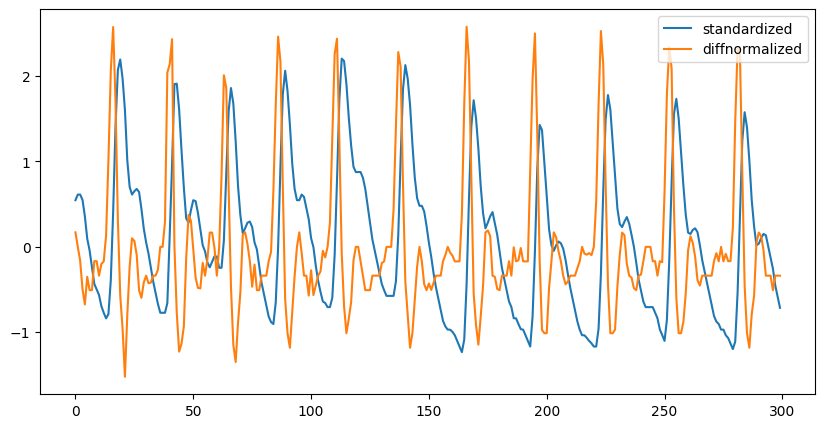

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load preprocessed dataset
data_path = "/mnt/16TB/rppg-datasets/pure/cached/fixedface_bbox1.5_resize128x128/01_01_label.npy"
label = np.load(data_path)

# Plot the label
chunk_length = 300
plt.figure(figsize=(10, 5))
# plt.plot(label[:chunk_length, 0], label="raw")
plt.plot(label[:chunk_length, 1], label="standardized")
plt.plot(label[:chunk_length, 2], label="diffnormalized")
plt.legend()
plt.show()

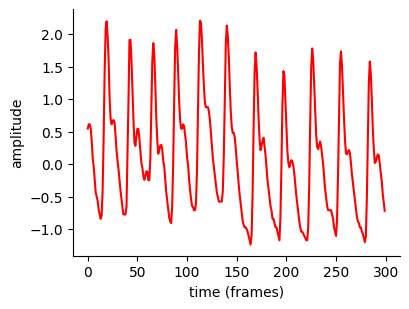

In [3]:
# Load preprocessed dataset
data_path = "/mnt/16TB/rppg-datasets/pure/cached/fixedface_bbox1.5_resize128x128/01_01_label.npy"
label = np.load(data_path)

# Plot the label
chunk_length = 300
plt.figure(figsize=(4, 3))
# plt.plot(label[:chunk_length, 0], label="raw")
plt.plot(label[:chunk_length, 1], label="standardized", color='red')
# plt.plot(label[:chunk_length, 2], label="diffnormalized")
plt.tight_layout()
# plt.gca().set_axis_off()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('time (frames)'); plt.ylabel('amplitude')

# Make background transparent
plt.gcf().patch.set_alpha(0.5)
plt.gca().patch.set_alpha(0.5)

# Save figure before showing
plt.savefig('ppg_sample.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

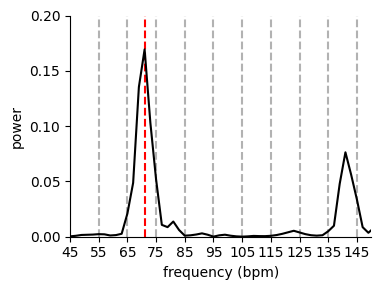

In [4]:
from evaluation.visualization import create_psd_figure, plot_psd
import matplotlib.pyplot as plt
import numpy as np

idx = 50
freq_sample = np.arange(45, 302, 2)
psd_sample = np.load('results/stats/PURE_psd_stats.npy')[idx]
hr_sample = np.load('results/stats/PURE_hr_stats.npy')[idx]
xlabel = 'frequency (bpm)'
ylabel = 'power'
plt.figure(figsize=(4, 3))
plt.xlim(45, 150); plt.ylim(0, 0.20)
xticks = np.arange(45, 151, 10)
plt.xticks(xticks)
plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.tight_layout()
for i in range(len(xticks)):
    plt.axvline(xticks[i], linestyle='--', color='black', alpha=0.3)
plt.axvline(hr_sample, color='red', linestyle='--')
plt.plot(freq_sample, psd_sample, color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gcf().patch.set_alpha(0.5)
plt.gca().patch.set_alpha(0.5)

plt.savefig('psd_sample.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()


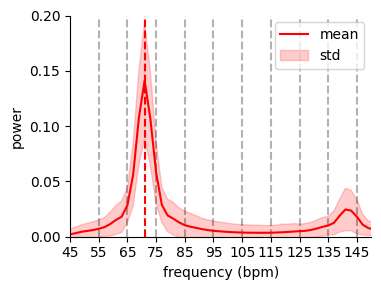

In [5]:
from evaluation.confidence_model import StatistcsConfidenceModel
from config import get_default_config

confidence_model = StatistcsConfidenceModel(get_default_config())
confidence_model.load("results/confidence_model/statistics")

hr_idx = 13
plot_psd_stats = confidence_model.psd_statistics
psd_mean = plot_psd_stats['psd_means'][hr_idx]
psd_covariance = plot_psd_stats['psd_covariances'][hr_idx]
sample_count = plot_psd_stats['sample_counts'][hr_idx]
xlabel = 'frequency (bpm)'
ylabel = 'power'
plt.figure(figsize=(4, 3))
plt.xlim(45, 150); plt.ylim(0, 0.20)
xticks = np.arange(45, 151, 10)
plt.xticks(xticks)
plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.tight_layout()
for i in range(len(xticks)):
    plt.axvline(xticks[i], linestyle='--', color='black', alpha=0.3)

plt.axvline(hr_sample, color='red', linestyle='--')
plt.plot(freq_sample, psd_mean, color='red', label='mean')
psd_std = np.sqrt(np.diag(psd_covariance))
plt.fill_between(freq_sample, 
                psd_mean - psd_std, 
                psd_mean + psd_std, 
                color='red', 
                alpha=0.2,
                label='std')
            
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gcf().patch.set_alpha(0.5)
plt.gca().patch.set_alpha(0.5)

plt.savefig('psd_mean_std.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

# Visualization of learned PSD conditional distribution

In [2]:
import numpy as np

psd_stats_all = np.load(f'results/stats/all_psd_stats.npy')
hr_stats_all = np.load(f'results/stats/all_hr_stats.npy')
print(f"fit confidence model on {len(psd_stats_all)} samples for all datasets")

fit confidence model on 47945 samples for all datasets


In [1]:
from config import get_default_config
from evaluation.confidence_model import StatistcsConfidenceModel

confidence_model = StatistcsConfidenceModel(get_default_config())
confidence_model.load("results/confidence_model/statistics")
confidence_model.save_statistics_plots(save_path=f'results/svgs/refpsd')

100%|██████████| 54/54 [00:05<00:00, 10.42it/s]
